# **CHALLENGE IMA 205**
## **CLASSIFICATION OF DERMOSCOPIC IMAGES**
### **Classification notebook**
## Samia ABRIK

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf
# Configure TensorFlow to only allocate memory as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to true for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set successfully")
    except RuntimeError as e:
        # Memory growth must be set at program startup
        print(e)

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB7

## Load segmentation model 

In [ ]:
unet_model = load_model('UNet_model0.h5')

In [2]:
def predict_mask(image, model):
    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Add batch dimension and predict  
    pred_mask = pred_mask.reshape((192,256)) # Remove channel dimension
    pred_mask = (pred_mask > 0.001).astype(np.uint8) # Binarize the mask
    return pred_mask

## Load train images

In [21]:
train_images = []
images_path = os.path.join('ima205-challenge-2024/Train/Train')
for img in sorted(os.listdir(images_path)):
    if img.endswith('jpg'):  
        image_path = os.path.join(images_path, img)
        image = plt.imread(image_path)
        image = cv2.resize(image, (256, 192))
        train_images.append(image)
train_images = np.array(train_images).astype('uint8') 
print('Number of train images :', len(train_images))

Number of train images : 18998


## Save predicted masks

In [ ]:
# Calculating predicted masks for once and saving them in a folder
train_masks = [predict_mask(img, unet_model) for img in train_images]
df_train = pd.read_csv('ima205-challenge-2024/metadataTrain.csv') 
IDs = df_train['ID']
IDs  = IDs.sort_values()
IDs_train = IDs.values
save_dir = 'ima205-challenge-2024/predicted_masks/train'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i, mask in enumerate(train_masks):
    # Normalize and convert the mask
    mask = (mask * 255).astype(np.uint8)
    # Define the image file path
    mask_path = os.path.join(save_dir, f'{IDs_train[i]}_mask.png')
    # Save the image
    imageio.imwrite(mask_path, mask)

## Load saved predicted masks

In [2]:
train_masks_saved = []
masks_path = 'ima205-challenge-2024/predicted_masks/train'
mask_files = sorted(os.listdir(masks_path))
for img in mask_files: 
    mask_path = os.path.join(masks_path, img)
    mask = plt.imread(mask_path)
    mask = mask.astype('uint8') 
    train_masks_saved.append(mask)
train_masks_saved = np.array(train_masks_saved)
print('Number of train masks :', len(train_masks_saved))

Number of train masks : 18998


## Calculating segmentations

Segmented images are calculated by mutiplying each image by its corresponding predicted mask. The result is then resized to match the input size of the model later.

In [4]:
train_segs = []
# Iterate over each pair of image and mask in the training sets
for i in range(len(train_images)):
    image = train_images[i]
    mask = train_masks_saved[i]
    mask = mask[:, :, np.newaxis]  # Add a new axis to match image dimensions
    # Create segmented image by element-wise multiplication
    segmentation = image * mask
    # Resize image
    segmentation = cv2.resize(segmentation, (224, 224))
    # Append the segmented image to the list
    train_segs.append(segmentation)

train_segs = np.array(train_segs)
print('Number of segmentation images in the train set:', len(train_segs))

Number of segmentation images in the train set: 18998


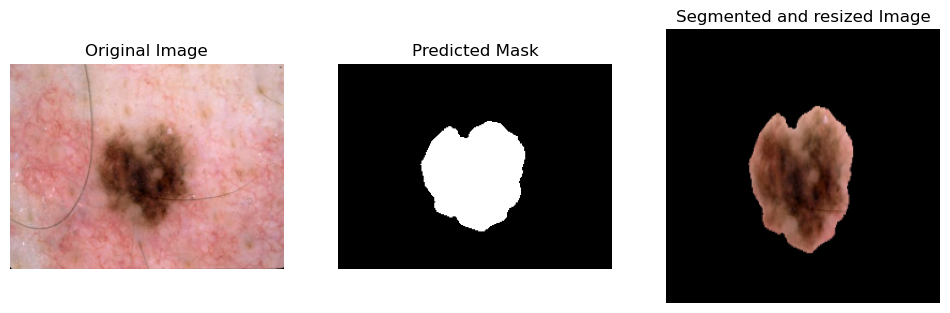

In [5]:
for i in range(1):
    c=1789
    expl_image = train_images[i+c]
    expl_mask = train_masks_saved[i+c]
    expl_seg = train_segs[i+c]  

    plt.figure(figsize=(12, 4))  

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(expl_image)
    plt.title('Original Image')
    plt.axis('off')  

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.imshow(expl_mask, cmap='gray')  
    plt.title('Predicted Mask')
    plt.axis('off')

    # Plot the segmented image
    plt.subplot(1, 3, 3)
    plt.imshow(expl_seg)
    plt.title('Segmented and resized Image')
    plt.axis('off')

    plt.show()  

## Train labels

In [ ]:
# Train labels
df_train = pd.read_csv('ima205-challenge-2024/metadataTrain.csv') 
labels = pd.DataFrame(df_train[['ID', 'CLASS']])
labels = labels.sort_values(by='ID').reset_index(drop=True)
labels = np.array(labels["CLASS"])
print(labels)

In [4]:
# One-hot encoding
train_labels = to_categorical(labels-1) # -1 because the classes are 1, 2, 3, 4, 5, 6, 7, 8
print(train_labels.shape)

(18998, 8)


## Data augmentation

In [8]:
labels_augmented = []
segs_augmented = []
for i in range(len(train_segs)):
    label = labels[i]
    seg = train_segs[i]
    if label in [4,6,7,8]:
        rot90 = cv2.rotate(seg, cv2.ROTATE_90_CLOCKWISE)
        rot180 = cv2.rotate(seg, cv2.ROTATE_180)
        rot270 = cv2.rotate(seg, cv2.ROTATE_90_COUNTERCLOCKWISE)
        flip1 = cv2.flip(seg, 1)
        flip0 = cv2.flip(seg, 0)
        segs_augmented.append(rot90)
        segs_augmented.append(rot180)
        segs_augmented.append(rot270)
        segs_augmented.append(flip1)
        segs_augmented.append(flip0)
        for _ in range(5):
            labels_augmented.append(label)

    elif label == 1:
        rot90 = cv2.rotate(seg, cv2.ROTATE_90_CLOCKWISE)
        rot180 = cv2.rotate(seg, cv2.ROTATE_180)
        segs_augmented.append(rot90)
        segs_augmented.append(rot180)
        labels_augmented.append(label)
        labels_augmented.append(label)
    elif label == 3:
        rot90 = cv2.rotate(seg, cv2.ROTATE_90_CLOCKWISE)
        rot180 = cv2.rotate(seg, cv2.ROTATE_180)
        rot270 = cv2.rotate(seg, cv2.ROTATE_90_COUNTERCLOCKWISE)
        segs_augmented.append(rot90)
        segs_augmented.append(rot180)
        segs_augmented.append(rot270)
        for _ in range(3):
            labels_augmented.append(label)

    elif label == 5:
        rot90 = cv2.rotate(seg, cv2.ROTATE_90_CLOCKWISE)
        rot180 = cv2.rotate(seg, cv2.ROTATE_180)
        rot270 = cv2.rotate(seg, cv2.ROTATE_90_COUNTERCLOCKWISE)
        flip1 = cv2.flip(seg, 1)
        segs_augmented.append(rot90)
        segs_augmented.append(rot180)
        segs_augmented.append(rot270)
        segs_augmented.append(flip1)
        for _ in range(4):
            labels_augmented.append(label)


segs_augmented = np.array(segs_augmented)

In [9]:
# Concatenate the augmented data to the original data
train_segs_augmented = np.concatenate((train_segs, segs_augmented))
print(train_segs_augmented.shape)

# Concatenate the augmented labels to the original labels
train_labels_augmented = np.concatenate((labels, labels_augmented))
print(len(train_labels_augmented))

# One-hot encoding
train_labels_augmented = to_categorical(train_labels_augmented-1)
print(train_labels_augmented.shape)

(48578, 224, 224, 3)
48578
(48578, 8)


## Split the data into train and validation sets

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train_segs_augmented, train_labels_augmented, test_size=0.18, random_state=42)

In [11]:
# Add the given weights 
weights = [ 0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
class_weights = {i: weights[i] for i in range(len(weights))}

## Build Model

In [14]:
def enhanced_classification_model(input_size=(224, 224, 3)):
    inputs = Input(shape=input_size)

    # First Convolution Block
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
    c1 = BatchNormalization(name='bn1_1')(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(c1)
    c1 = BatchNormalization(name='bn1_2')(c1)
    c1 = MaxPooling2D((2, 2), name='pool1')(c1)

    # Second Convolution Block
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(c1)
    c2 = BatchNormalization(name='bn2_1')(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(c2)
    c2 = BatchNormalization(name='bn2_2')(c2)
    c2 = MaxPooling2D((2, 2), name='pool2')(c2)

    # Third Convolution Block
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(c2)
    c3 = BatchNormalization(name='bn3_1')(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(c3)
    c3 = BatchNormalization(name='bn3_2')(c3)
    c3 = MaxPooling2D((2, 2), name='pool3')(c3)

    # Flatten and Dense Layers
    f1 = Flatten()(c3)
    d1 = Dense(1024, activation='relu', name='dense1')(f1)
    outputs = Dense(8, activation='softmax')(d1)

    # Create the model
    model = Model(inputs, outputs, name='EnhancedClassificationModel')

    return model

with tf.device('/gpu:2'):
    class_model = enhanced_classification_model()
    class_model.summary()

Model: "EnhancedClassificationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 bn1_1 (BatchNormalization)  (None, 224, 224, 64)      256       
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 bn1_2 (BatchNormalization)  (None, 224, 224, 64)      256       
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112

## Training 

In [15]:
# Create an EarlyStopping callback instance
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=7,        
    restore_best_weights=True  
)

with tf.device('/gpu:2'):
    # Compile the model
    class_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',  
                        metrics=['accuracy'])
    # Fit the model
    history = class_model.fit(X_train, y_train,  
                        epochs=30,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        callbacks=early_stopping)

Epoch 1/30


2024-05-05 10:22:16.228478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2024-05-05 10:22:16.576249: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-05 10:22:18.428888: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x563cd6a94bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-05 10:22:18.428920: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2024-05-05 10:22:18.428925: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2024-05-05 10:22:18.428929: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2024-05-05 10:22:18.433944: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc

1245/1245 [==============================] - 197s 152ms/step - loss: 2.0308 - accuracy: 0.3905 - val_loss: 1.5101 - val_accuracy: 0.4362
Epoch 2/30
1245/1245 [==============================] - 186s 149ms/step - loss: 1.4191 - accuracy: 0.4637 - val_loss: 1.4986 - val_accuracy: 0.4374
Epoch 3/30
1245/1245 [==============================] - 183s 147ms/step - loss: 1.2913 - accuracy: 0.5184 - val_loss: 1.8205 - val_accuracy: 0.4320
Epoch 4/30
1245/1245 [==============================] - 186s 149ms/step - loss: 1.1571 - accuracy: 0.5673 - val_loss: 6.5987 - val_accuracy: 0.3879
Epoch 5/30
1245/1245 [==============================] - 184s 148ms/step - loss: 0.9810 - accuracy: 0.6374 - val_loss: 1.8563 - val_accuracy: 0.4218
Epoch 6/30
1245/1245 [==============================] - 184s 147ms/step - loss: 0.7747 - accuracy: 0.7157 - val_loss: 1.8220 - val_accuracy: 0.4529
Epoch 7/30
1245/1245 [==============================] - 182s 146ms/step - loss: 0.5432 - accuracy: 0.8075 - val_loss: 1.989

## Setting Up and Training the EfficientNetB7 Model 

In [13]:
with tf.device('/gpu:1'):
    
    # Load the EfficientNetB7 model without the top layer, pre-trained on the ImageNet dataset
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Get the output layer of the pre-trained model.
    x = base_model.output
    
    # Apply global average pooling to the output of the base model to reduce the number of parameters in the model.
    x = GlobalAveragePooling2D()(x)
    
    # Add a fully connected layer to output 8 classes. Use softmax activation to get probabilities for each class for multi-class classification.
    predictions = Dense(8, activation='softmax')(x)

    # Create the full model by specifying the inputs to the base model and the outputs to the new dense layer.
    modelB7 = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model, setting up the optimizer, loss function, and metrics to monitor.
    modelB7.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Set up early stopping to monitor the validation loss.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit the model
    historyB7 = modelB7.fit(X_train, y_train,  
                        epochs=20,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        verbose=1,
                        class_weight=class_weights,
                        callbacks=[early_stopping])  # Include early stopping in the training process

Epoch 1/20


2024-04-30 18:33:51.844647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-30 18:33:59.452773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2024-04-30 18:33:59.856415: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-30 18:34:00.173322: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55fbd2cc8700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-30 18:34:00.173362: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2024-04-30 18:34:00.173367: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100S-PCIE-32G

1245/1245 [==============================] - 735s 510ms/step - loss: 1.7518 - accuracy: 0.4839 - val_loss: 0.9542 - val_accuracy: 0.6579
Epoch 2/20
1245/1245 [==============================] - 629s 505ms/step - loss: 0.7612 - accuracy: 0.7012 - val_loss: 0.7402 - val_accuracy: 0.7372
Epoch 3/20
1245/1245 [==============================] - 628s 505ms/step - loss: 0.4389 - accuracy: 0.7993 - val_loss: 0.5849 - val_accuracy: 0.7930
Epoch 4/20
1245/1245 [==============================] - 628s 505ms/step - loss: 0.3036 - accuracy: 0.8469 - val_loss: 0.4833 - val_accuracy: 0.8314
Epoch 5/20
1245/1245 [==============================] - 628s 505ms/step - loss: 0.2691 - accuracy: 0.8726 - val_loss: 0.3898 - val_accuracy: 0.8604
Epoch 6/20
1245/1245 [==============================] - 628s 504ms/step - loss: 0.2017 - accuracy: 0.8970 - val_loss: 0.5055 - val_accuracy: 0.8269
Epoch 7/20
1245/1245 [==============================] - 629s 505ms/step - loss: 0.1662 - accuracy: 0.9103 - val_loss: 0.373

## Feature extraction

### **1. Asymmetry index**

In [5]:
def calculate_asymmetry_index(mask):
    reflected_mask = cv2.flip(mask, 1)

    intersection = cv2.bitwise_and(mask, reflected_mask)
    union = cv2.bitwise_or(mask, reflected_mask)

    asymmetry_index = np.sum(intersection) / np.sum(union)

    return round(asymmetry_index, 2)

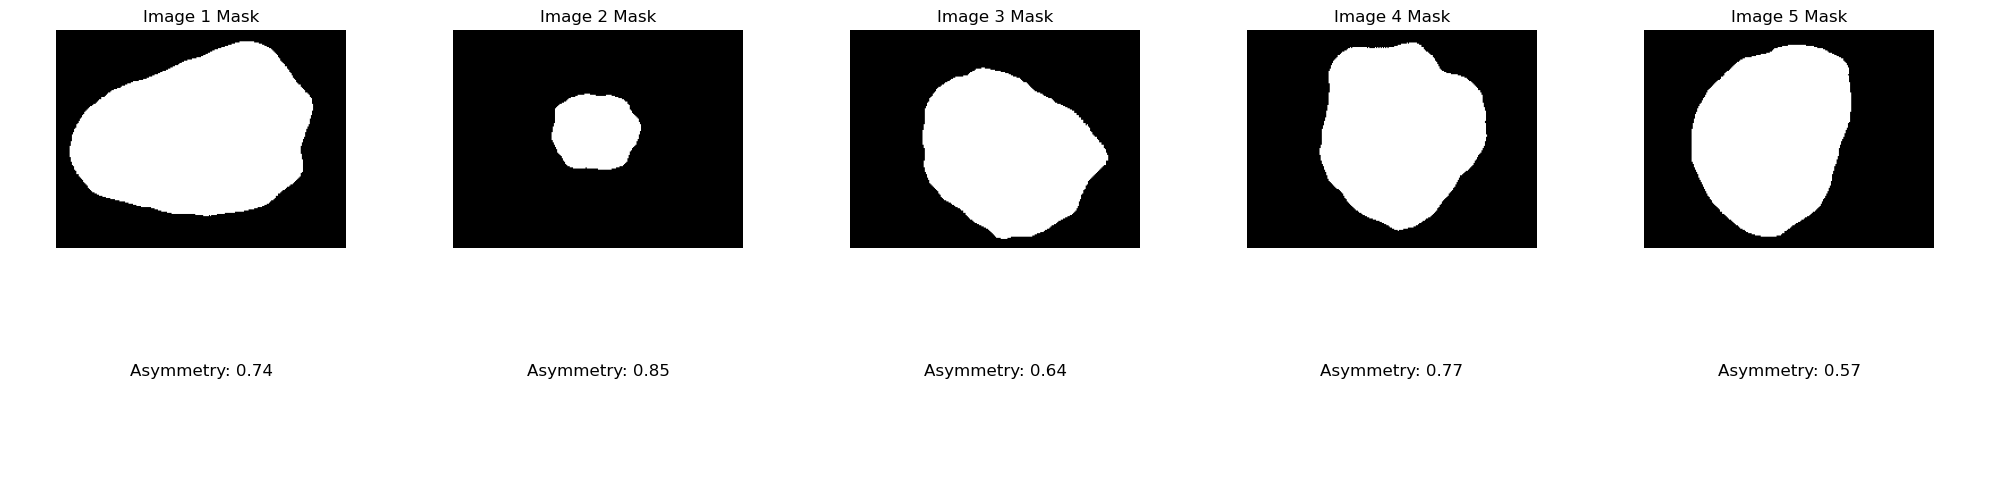

In [37]:
plt.figure(figsize=(20, 5))
for i in range(5):
    example_mask = train_masks_saved[i]
    asymmetry = calculate_asymmetry_index(example_mask)

    plt.subplot(2, 5, i+1)
    plt.imshow(example_mask, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1} Mask')

    plt.subplot(2, 5, 6 + i)
    plt.text(0.5, 0.5, f"Asymmetry: {asymmetry}", ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

### **2. Border irregularity**

### 2.1. Index compact

In [27]:
def calculate_compactness(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return 1.0
    
    contour = max(contours, key=cv2.contourArea)

    perimeter = cv2.arcLength(contour, closed=True)
    area = cv2.contourArea(contour)

    if area == 0:
        return 1 
    
    compactness = (perimeter ** 2) / (4 * np.pi * area)

    return round(compactness,2)

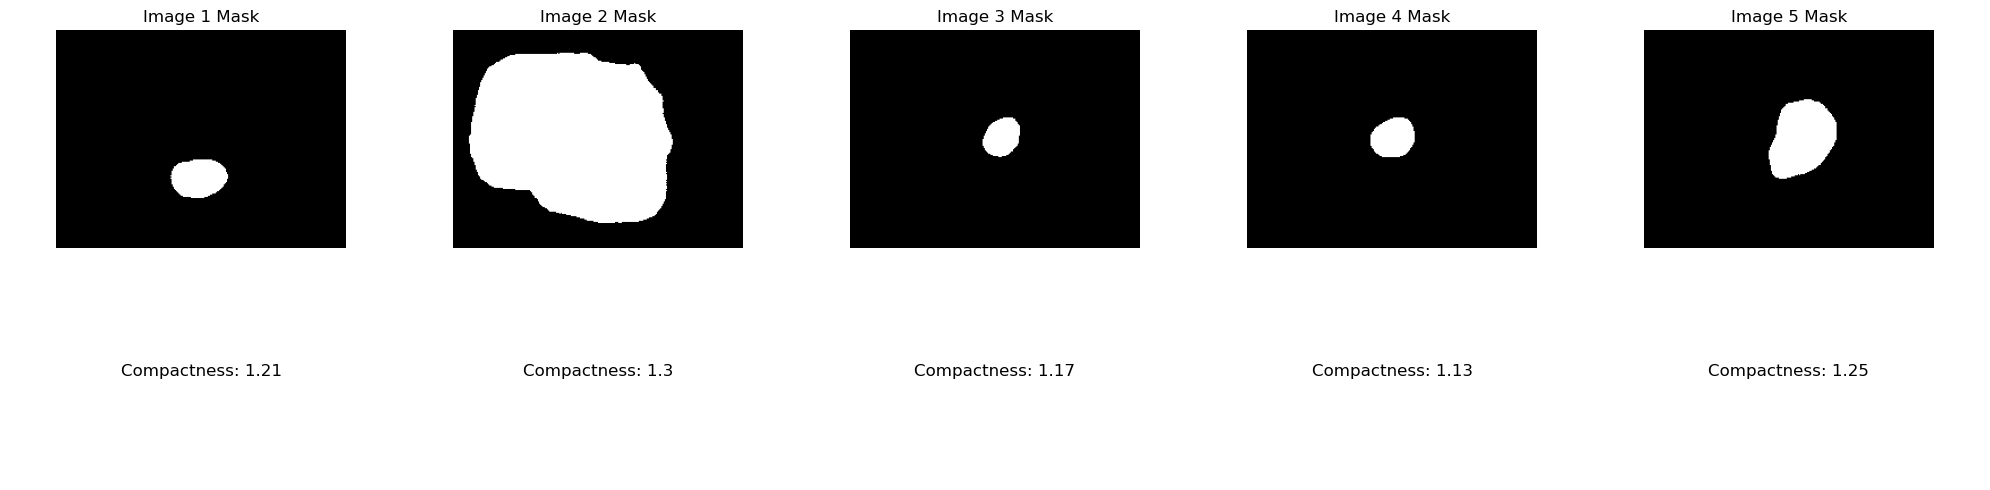

In [8]:
plt.figure(figsize=(20, 5))
for i in range(5):
    example_mask = train_masks_saved[i+1000]
    compactness = calculate_compactness(example_mask)

    plt.subplot(2, 5, i+1)
    plt.imshow(example_mask, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1} Mask')
    
    plt.subplot(2, 5, 6 + i)
    plt.text(0.5, 0.5, f"Compactness: {compactness}", ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 2.2. Fractal dimension 

In [9]:
def calculate_fractal_dimension(mask):
    num_boxes = []

    # Iterate over different box sizes (r)
    for r in range(1, min(mask.shape) // 2):
        # Create a grid of boxes with size r
        num_x_boxes = mask.shape[1] // r
        num_y_boxes = mask.shape[0] // r

        # Count the number of boxes that intersect with the contour
        count = 0
        for i in range(num_x_boxes):
            for j in range(num_y_boxes):
                box = mask[j * r:(j + 1) * r, i * r:(i + 1) * r]
                if np.any(box):
                    count += 1

        num_boxes.append(count)

    # Fit a linear regression line to log-log plot of N(r) vs r
    r_values = np.arange(1, min(mask.shape) // 2)
    num_boxes = np.array(num_boxes)
    log_r_values = np.log(r_values)
    log_num_boxes = np.log(num_boxes)

    coeffs = np.polyfit(log_r_values, log_num_boxes, 1)
    fractal_dimension = -coeffs[0]

    return round(fractal_dimension,2)

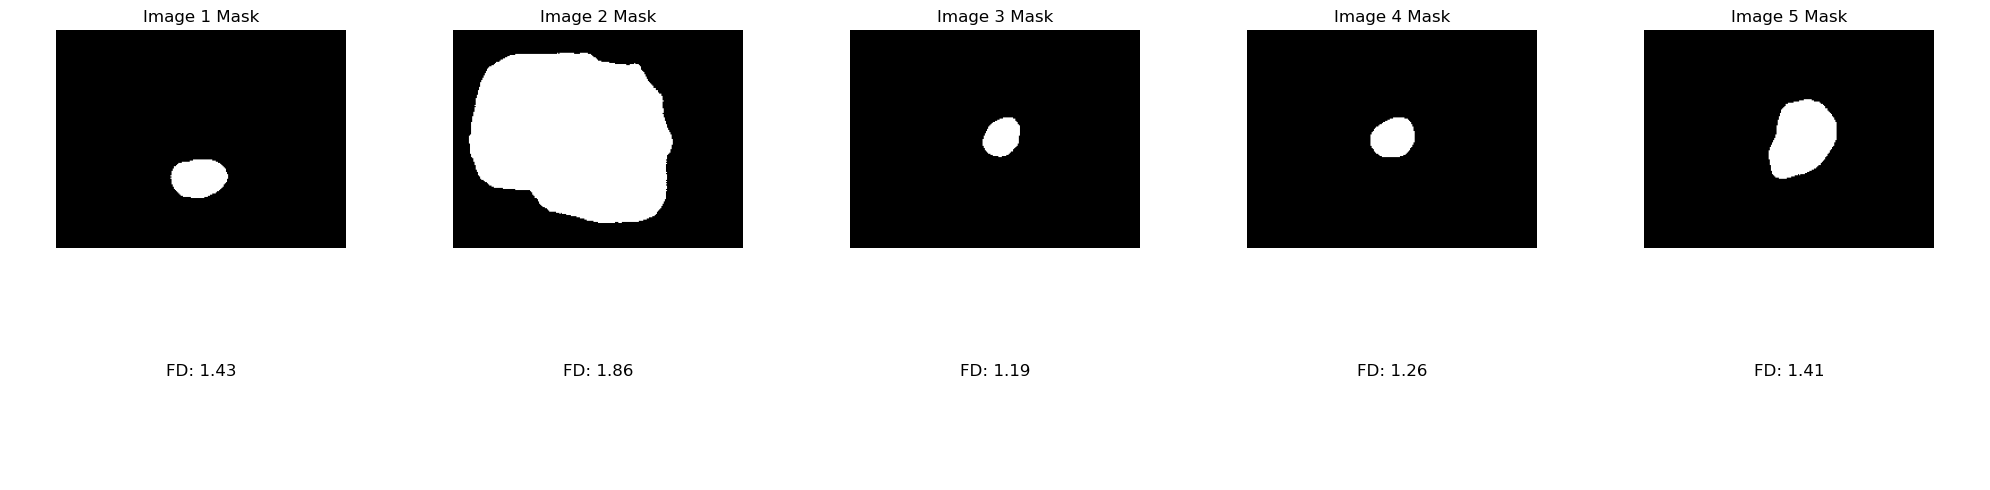

In [10]:
plt.figure(figsize=(20, 5))
for i in range(5):
    example_mask = train_masks_saved[i+1000]
    fractal_dimension = calculate_fractal_dimension(example_mask)

    plt.subplot(2, 5, i+1)
    plt.imshow(example_mask, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1} Mask')
   
    plt.subplot(2, 5, 6 + i)
    plt.text(0.5, 0.5, f"FD: {fractal_dimension}", ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 2.3. Radial variance and Border parameter

In [33]:
def calculate_rv_bp(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return 0.01, 1.0

    contour = max(contours, key=cv2.contourArea)

    M = cv2.moments(contour)
    if M["m00"] == 0:
        return 0.01, 1.0

    centroid_x = int(M["m10"] / M["m00"])
    centroid_y = int(M["m01"] / M["m00"])

    distances = [np.sqrt((point[0][0] - centroid_x) ** 2 + (point[0][1] - centroid_y) ** 2) for point in contour]

    mean_distance = np.mean(distances)

    radial_variance = (1 / len(contour)) * np.sum(((distances - mean_distance) ** 2) / (mean_distance ** 2))

    lesion_area = cv2.contourArea(contour)
    circle_area = np.pi * (mean_distance ** 2)

    border_parameter = circle_area / lesion_area

    return round(radial_variance,4), round(border_parameter,4)

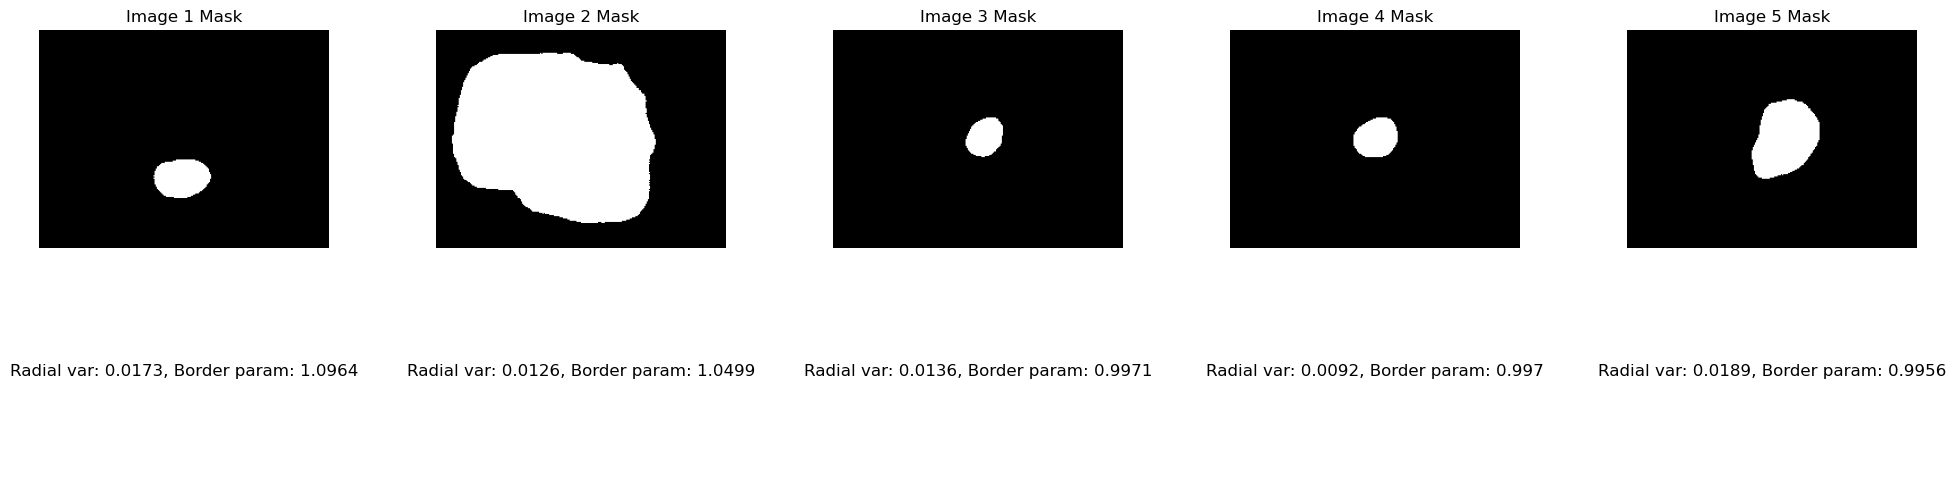

In [12]:
plt.figure(figsize=(20, 5))
for i in range(5):
    example_mask = train_masks_saved[i+1000]
    rv_bp = calculate_rv_bp(example_mask)
    
    plt.subplot(2, 5, i+1)
    plt.imshow(example_mask, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1} Mask')
   
    plt.subplot(2, 5, 6 + i)
    plt.text(0.5, 0.5, f"Radial var: {rv_bp[0]}, Border param: {rv_bp[1]}", ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Calculate the features for the train set

In [ ]:
asymmetry_indices_train = []
for mask in train_masks_saved:
    asymmetry_index = calculate_asymmetry_index(mask)
    asymmetry_indices_train.append(asymmetry_index)
print('Number of asymmetry indices:', len(asymmetry_indices_train))

compactness_train = []
for mask in train_masks_saved:
    compactness = calculate_compactness(mask)
    compactness_train.append(compactness)
print('Number of compactness:', len(compactness_train))

# fd_train = []
# for mask in train_masks_saved:
#     fd = calculate_fractal_dimension(mask)
#     fd_train.append(fd)
# print('Number of fd:', len(fd_train))

rv_train = []
bp_train = []
for mask in train_masks_saved:
    rv, bp = calculate_rv_bp(mask)
    rv_train.append(rv)
    bp_train.append(bp)
print('Number of rv:', len(rv_train))
print('Number of bp:', len(bp_train))

In [ ]:
df_train = pd.read_csv('ima205-challenge-2024/metadataTrain.csv') 
IDs_train = df_train['ID']
IDs_train = IDs_train.sort_values()
df_train= df_train.sort_values(by='ID')
df_train.reset_index(drop=True, inplace=True)
N_train,M_train=df_train.shape

train_features_df = df_train.iloc[:,2:]
train_features_df['ASYMMETRY'] = asymmetry_indices_train
train_features_df['COMPACTNESS'] = compactness_train
train_features_df['RADIAL Var'] = rv_train
train_features_df['BORDER Param'] = bp_train
train_features_df.head()

In [52]:
X_train = train_features_df.values

# Train labels
df_train = pd.read_csv('ima205-challenge-2024/metadataTrain.csv') 
labels = pd.DataFrame(df_train[['ID', 'CLASS']])
labels = labels.sort_values(by='ID').reset_index(drop=True)
y_train = np.array(labels["CLASS"])

In [54]:
# To handle NaN
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_train)
X_train = imp.transform(X_train)

# To handle categorical data
for i in range(N_train):
    if X_train[i,0]=='male':
        X_train[i,0]=0
    elif X_train[i,0]=='female':
        X_train[i,0]=1

categorical_feature_index = 2
X_train_categorical = X_train[:, categorical_feature_index].reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)  
encoder.fit(X_train_categorical)
X_train_encoded = encoder.transform(X_train_categorical)
X_train = np.delete(X_train, categorical_feature_index, axis=1)
X_train = np.concatenate([X_train, X_train_encoded], axis=1)

In [56]:
# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)

In [58]:
from sklearn.utils import shuffle
X_train, train_labels = shuffle(X_train, y_train, random_state=666)

In [77]:
# Random Forest
RF = RandomForestClassifier(random_state=666)
p_grid_RF = {'n_estimators': [10,20,50], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='balanced_accuracy', cv=5, n_jobs=4)
grid_RF.fit(X_train_scale, y_train)

print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Score: 0.22325069192241723
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 50}


## Prediction

### 1. Using CNN

Apply the same pre-processing for the test set as the train set :

In [61]:
# Load test images
test_images = []
images_path = os.path.join('ima205-challenge-2024/Test/Test')
for img in sorted(os.listdir(images_path)):
    if img.endswith('jpg'):  
        image_path = os.path.join(images_path, img)
        image = plt.imread(image_path)
        image = cv2.resize(image, (256, 192))
        test_images.append(image)
test_images = np.array(test_images).astype('uint8') 
print('Number of test images :', len(test_images))

# Calculating predicted masks for once and saving them in a folder
#test_masks = [predict_mask(img, unet_model) for img in test_images]
# save_dir = 'ima205-challenge-2024/predicted_masks/test'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# for i, mask in enumerate(test_masks):
#     # Normalize and convert the mask
#     mask = (mask * 255).astype(np.uint8)
#     # Define the image file path
#     mask_path = os.path.join(save_dir, f'{IDs_test[i]}_mask.png')
#     # Save the image
#     imageio.imwrite(mask_path, mask)

# Load saved predicted masks
test_masks_saved = []
masks_path = 'ima205-challenge-2024/predicted_masks/test'
mask_files = sorted(os.listdir(masks_path))
for img in mask_files: 
    mask_path = os.path.join(masks_path, img)
    mask = plt.imread(mask_path)
    mask = mask.astype('uint8')
    test_masks_saved.append(mask)
test_masks_saved = np.array(test_masks_saved)
print('Number of test masks :', len(test_masks_saved))

Number of test images : 6333
Number of test masks : 6333


In [15]:
# Calculating test segmentations
test_segs = []
# Iterate over each pair of image and mask in the test sets
for i in range(len(test_images)):
    image = test_images[i]
    mask = test_masks_saved[i]
    mask = mask[:, :, np.newaxis]  # Add a new axis to match image dimensions
    # Create segmented image by element-wise multiplication
    segmentation = image * mask
    # Resize image
    segmentation = cv2.resize(segmentation, (224, 224))
    # Append the segmented image to the list
    test_segs.append(segmentation)

test_segs = np.array(test_segs)
print('Number of segmentation images in the test set:', len(test_segs))

Number of segmentation images in the test set: 6333


In [16]:
with tf.device('/gpu:1'):  
    # Predict the labels of the test set
    test_labels = modelB7.predict(test_segs)

198/198 [==============================] - 25s 108ms/step


In [18]:
# Convert the predicted labels to the class with the highest probability
predicted_classes = np.argmax(test_labels, axis=1) + 1 # +1 because the classes are 1, 2, 3, 4, 5, 6, 7, 8
print(len(predicted_classes))

6333


In [19]:
# Save the predicted classes to a CSV file
df_test = pd.read_csv('ima205-challenge-2024/metadataTest.csv') 
IDs = df_test['ID']
IDs  = IDs.sort_values()

data = {'ID': IDs, 'CLASS': predicted_classes}
df = pd.DataFrame(data)
df.to_csv('output.csv', index=False)

### 2. Using Random Forest

We calculate the same features for the test set :

In [ ]:
asymmetry_indices_test = []
for mask in test_masks_saved:
    asymmetry_index = calculate_asymmetry_index(mask)
    asymmetry_indices_test.append(asymmetry_index)
print('Number of asymmetry indices:', len(asymmetry_indices_test))

compactness_test = []
for mask in test_masks_saved:
    compactness = calculate_compactness(mask)
    compactness_test.append(compactness)
print('Number of compactness:', len(compactness_test))

# fd_test = []
# for mask in test_masks_saved:
#     fd = calculate_fractal_dimension(mask)
#     fd_test.append(fd)
# print('Number of fd:', len(fd_test))

rv_test = []
bp_test = []
for mask in test_masks_saved:
    rv, bp = calculate_rv_bp(mask)
    rv_test.append(rv)
    bp_test.append(bp)
print('Number of rv:', len(rv_test))
print('Number of bp:', len(bp_test))

In [ ]:
df_test = pd.read_csv('ima205-challenge-2024/metadataTest.csv') 
IDs_test = df_test['ID']
IDs_test = IDs_test.sort_values()
df_test= df_test.sort_values(by='ID')
df_test.reset_index(drop=True, inplace=True)
N_test,M_test=df_test.shape

test_features_df = df_test.iloc[:,1:]
test_features_df['ASYMMETRY'] = asymmetry_indices_test
test_features_df['COMPACTNESS'] = compactness_test
test_features_df['RADIAL Var'] = rv_test
test_features_df['BORDER Param'] = bp_test
test_features_df.head()

In [65]:
X_test = test_features_df.values

In [67]:
X_test = imp.transform(X_test)

for i in range(N_test):
    if X_test[i,0]=='male':
        X_test[i,0]=0
    elif X_test[i,0]=='female':
        X_test[i,0]=1

X_test_categorical = X_test[:, categorical_feature_index].reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False) 
encoder.fit(X_test_categorical)
X_test_encoded = encoder.transform(X_test_categorical)
X_test = np.delete(X_test, categorical_feature_index, axis=1)
X_test = np.concatenate([X_test, X_test_encoded], axis=1)

In [69]:
X_test_scale=scaler.transform(X_test)

In [70]:
# Make predictions using the best Random Forest classifier
y_pred_RF = grid_RF.predict(X_test_scale)

In [72]:
# Save the predicted classes to a CSV file
df_test = pd.read_csv('ima205-challenge-2024/metadataTest.csv') 
IDs = df_test['ID']
IDs  = IDs.sort_values()

data = {'ID': IDs, 'CLASS': y_pred_RF}
df = pd.DataFrame(data)
df.to_csv('output_RF.csv', index=False)